In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pathlib
import random
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from tensorflow import keras
import tensorflow_hub as hub
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras import callbacks,layers,models,applications,optimizers,mixed_precision
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import TensorBoard
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow_datasets as tfds

In [2]:
def Preprocess_Image(image,label,shape=224):
    image=tf.image.resize(image,[shape,shape]) #resize image to standard
    return (tf.cast(image,dtype=tf.float32),label) 

In [3]:
(train_data, test_data), ds_info=tfds.load("food101",split=['train','validation'],shuffle_files=False,as_supervised=True,with_info=True)
class_names = ds_info.features["label"].names

In [4]:
train_data=train_data.map(map_func=Preprocess_Image,num_parallel_calls=tf.data.AUTOTUNE) #preprocess data
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) # shuffle and put into batches with prefetching
test_data = test_data.map(Preprocess_Image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
base_model = applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False
base_model.trainable=False
inputs=layers.Input(shape=(224,224,3),name="Input Layer")
x=base_model(inputs,training=False)
x=layers.GlobalAveragePooling2D()(x)
#float 32 output layer
outputs=Dense(len(class_names),activation="softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizers.Adam(0.0001),metrics="accuracy")

In [6]:
#model.evaluate(test_data)

In [7]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [8]:
model.load_weights(checkpoint_path)

In [9]:
#model.evaluate(test_data)

In [10]:
y_pred=model.predict(test_data)

790/790 [==============================] - 67s 72ms/step


In [11]:
y_pred.shape

(25250, 101)

In [12]:
y_labels = tf.concat([y for x, y in test_data], axis=0)

In [13]:
pred_classes = y_pred.argmax(axis=1)
pred_classes

array([29, 81, 91, ..., 76, 31, 21])

In [14]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [15]:
class_names = ds_info.features["label"].names

In [16]:
len(y_labels),len(pred_classes)

(25250, 25250)

In [17]:
confusion_matrix(y_labels,pred_classes)

array([[125,   0,  12, ...,   1,   0,   6],
       [  0, 175,   0, ...,   0,   1,   0],
       [ 10,   0, 186, ...,   1,   0,   0],
       ...,
       [  4,   1,   3, ..., 157,   0,   3],
       [  0,   0,   0, ...,   0, 126,   0],
       [  1,   0,   0, ...,   0,   0, 211]])

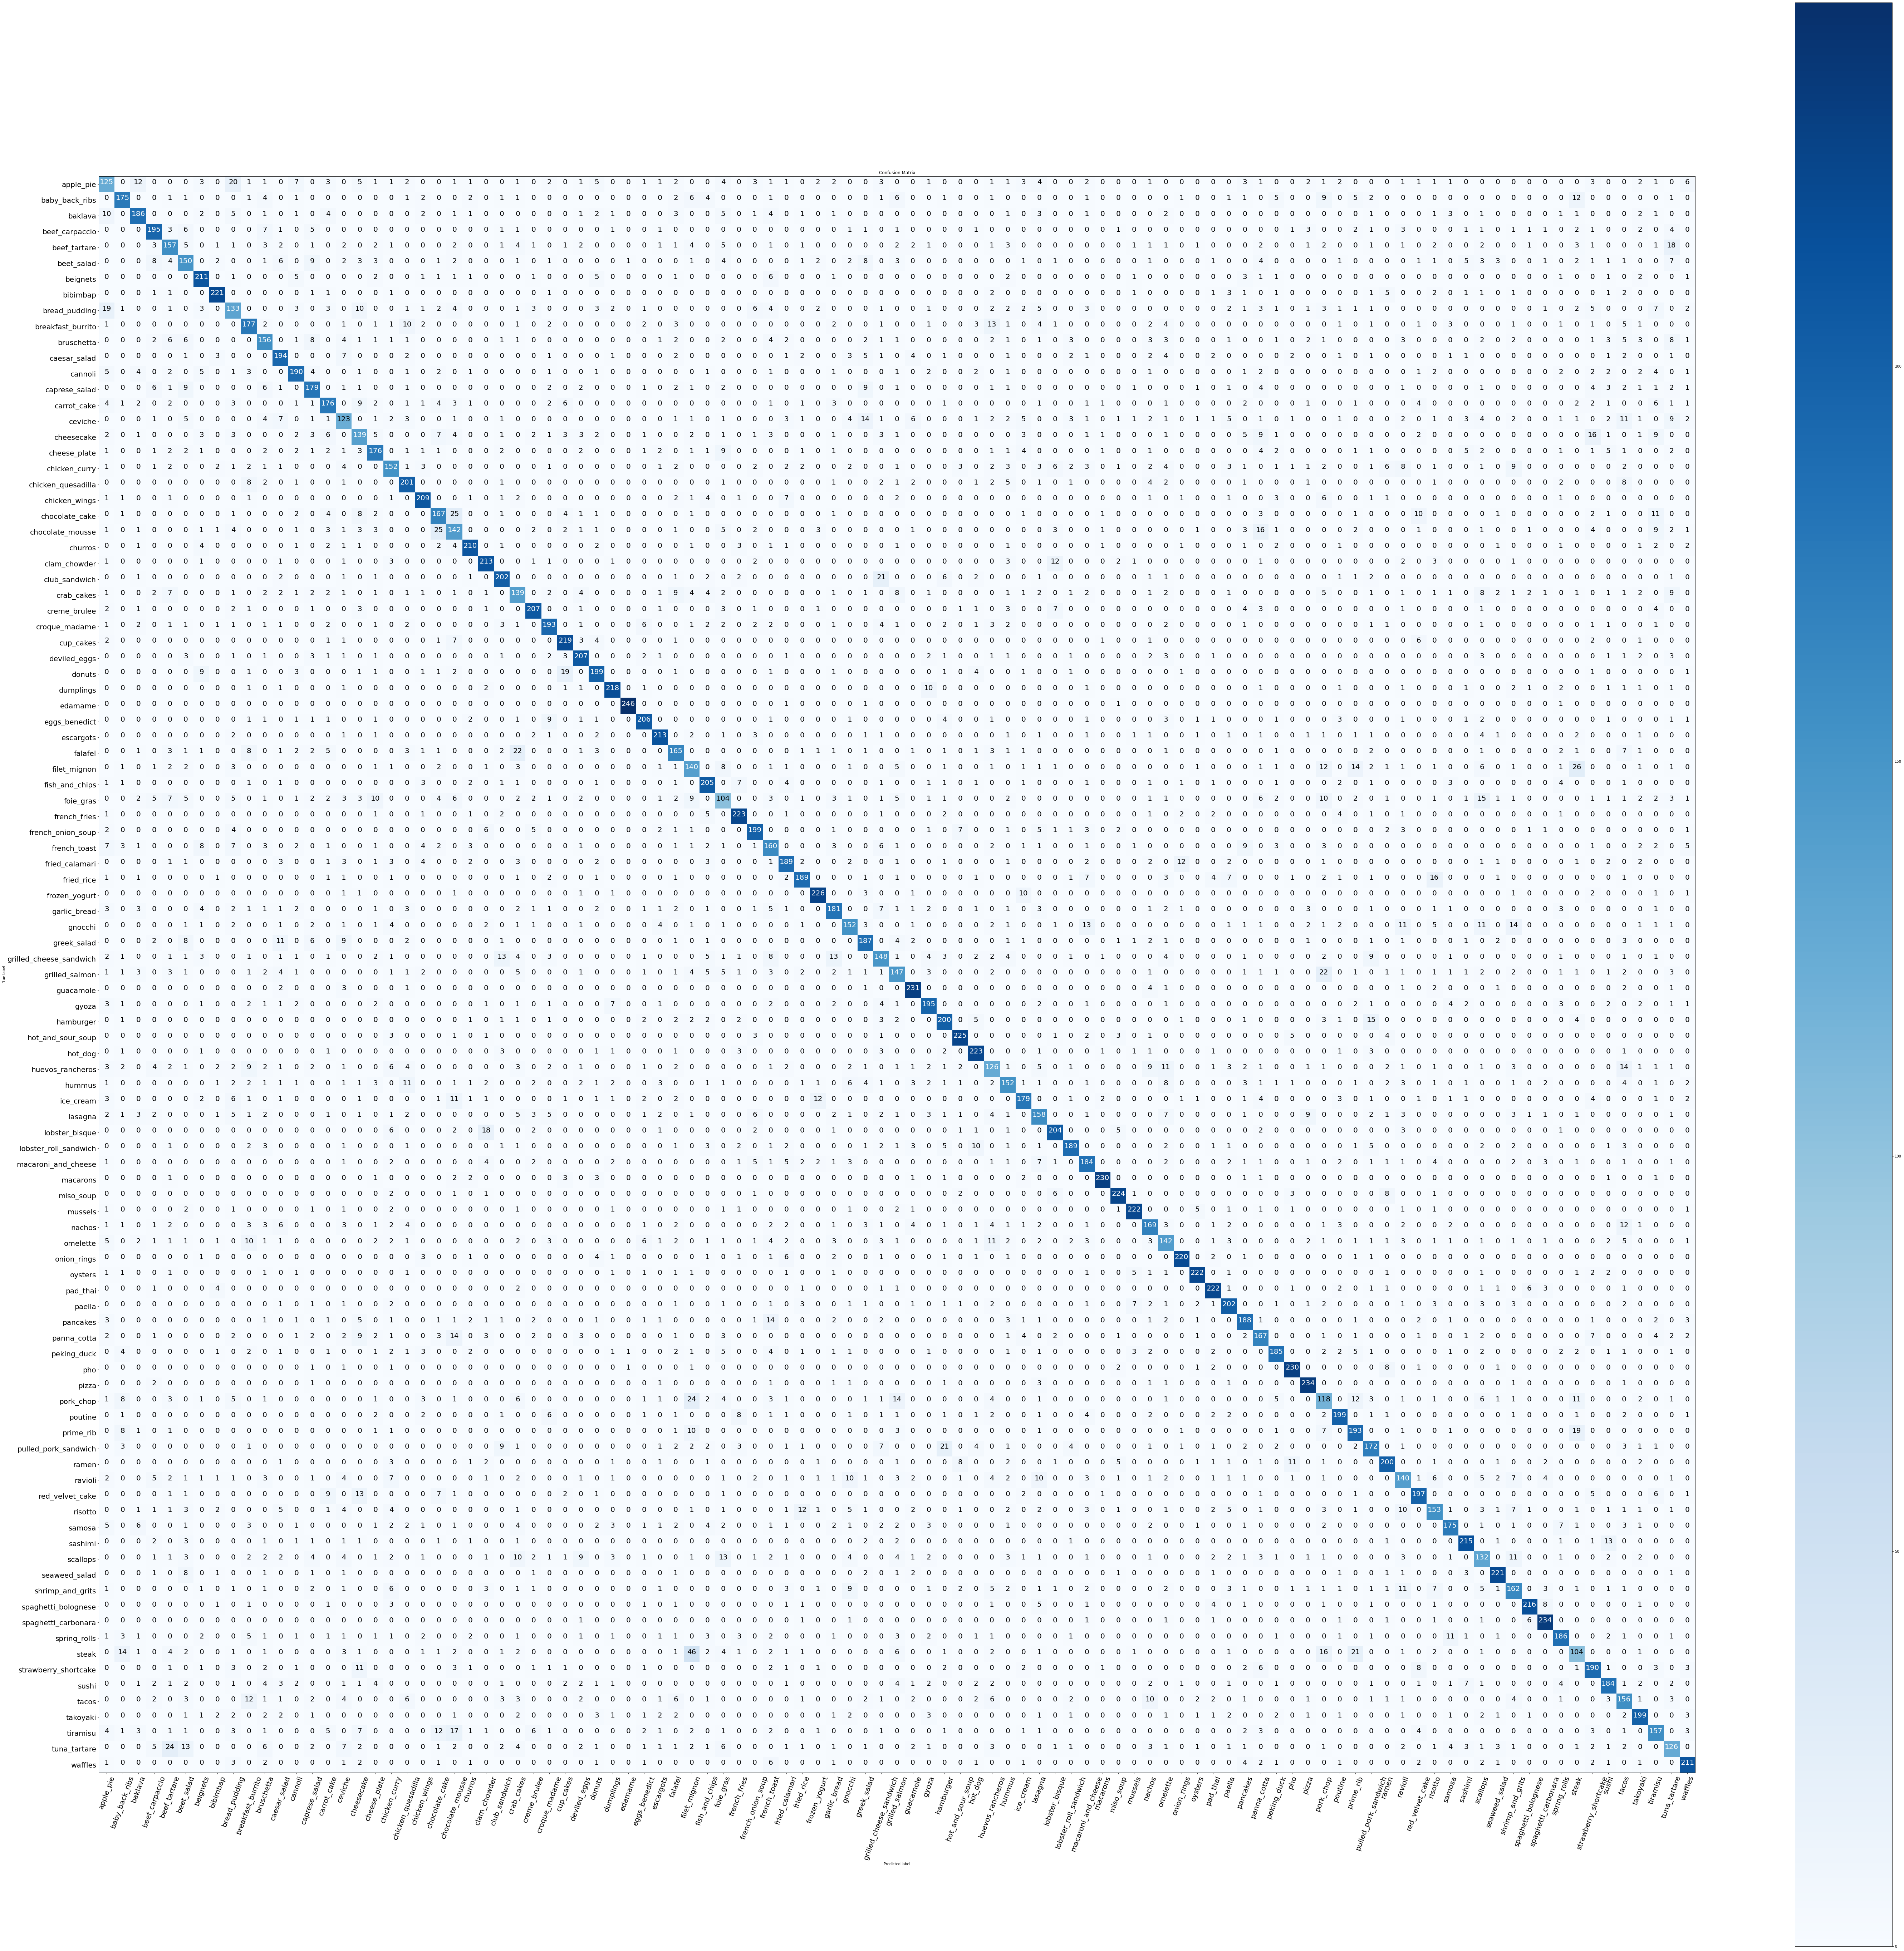

In [18]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.53      0.50      0.51       250
           1       0.74      0.70      0.72       250
           2       0.77      0.74      0.76       250
           3       0.75      0.78      0.77       250
           4       0.61      0.63      0.62       250
           5       0.59      0.60      0.59       250
           6       0.78      0.84      0.81       250
           7       0.89      0.88      0.89       250
           8       0.55      0.53      0.54       250
           9       0.67      0.71      0.69       250
          10       0.63      0.62      0.63       250
          11       0.72      0.78      0.74       250
          12       0.78      0.76      0.77       250
          13       0.70      0.72      0.71       250
          14       0.72      0.70      0.71       250
          15       0.56      0.49      0.52       250
          16       0.56      0.56      0.56       250
          17       0.71    

In [20]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [21]:
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

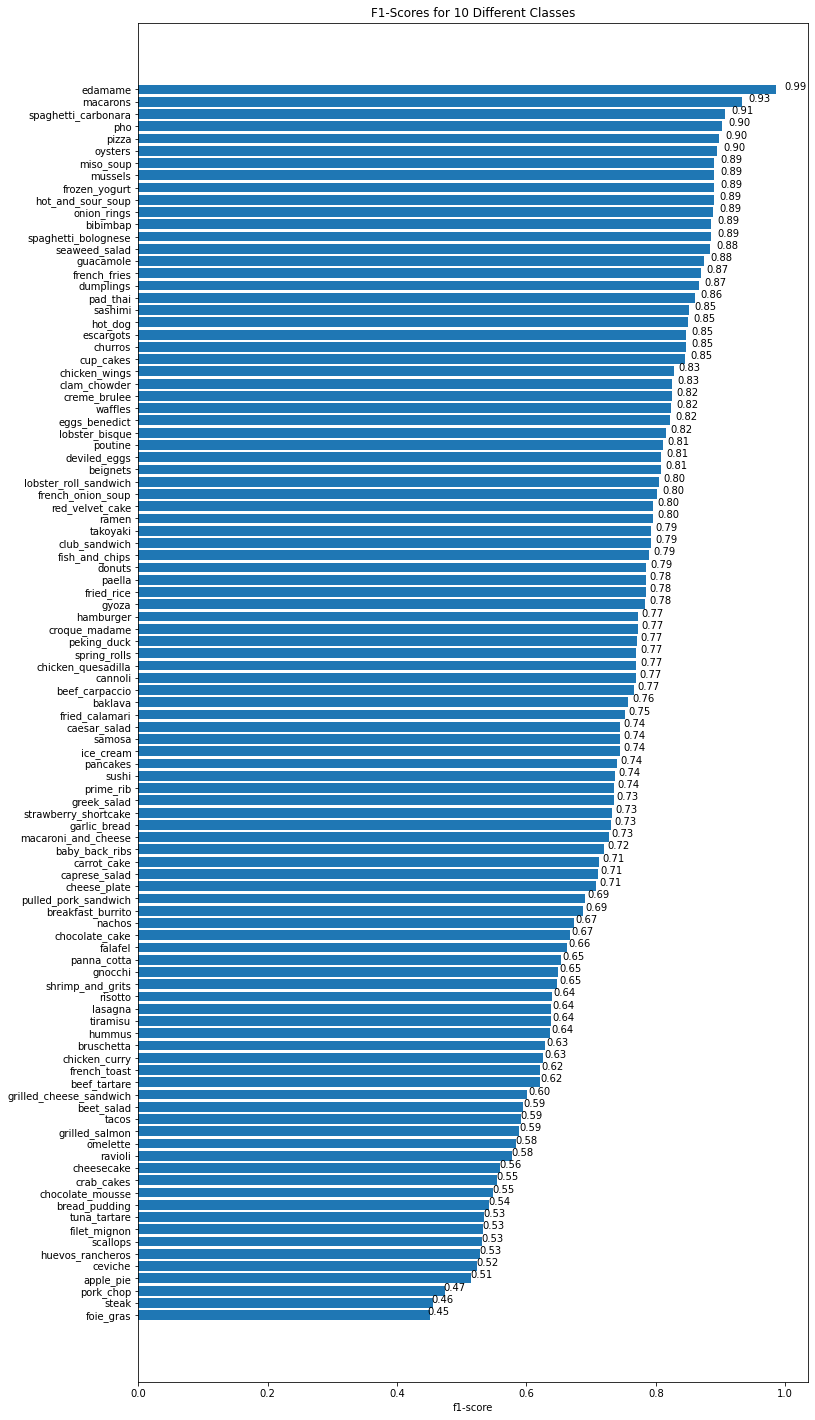

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

(1600, 1200, 3)

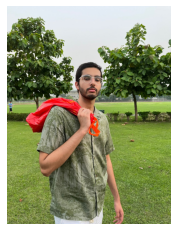

In [23]:
img = plt.imread('zobjpeg.jpeg')
plt.imshow(img);
plt.axis(False);
img.shape

1/1 [==============================] - 2s 2s/step


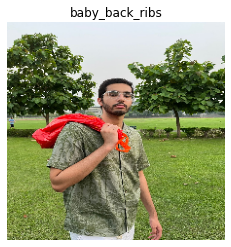

In [24]:
image=Preprocess_Image(img,' ')[0]
tf.reduce_min(image), tf.reduce_max(image)
pred=model.predict(tf.expand_dims(image, axis=0))
pred=pred.argmax()
plt.imshow(image/255)
plt.title(class_names[pred]) # add title to image by indexing on class_names list
plt.axis(False);

In [25]:
model.predict(tf.expand_dims(image, axis=0))

1/1 [==============================] - 0s 24ms/step


array([[9.46345564e-04, 1.38033316e-01, 2.32298320e-04, 5.50892786e-04,
        4.24366212e-03, 2.10539103e-04, 7.93822110e-03, 3.99343558e-02,
        2.17027482e-04, 4.48938285e-04, 4.45287063e-04, 2.31446829e-02,
        1.81004207e-03, 1.20824752e-02, 1.93472821e-02, 2.34074821e-03,
        2.76624933e-02, 4.72672703e-03, 7.88098387e-03, 7.93132000e-04,
        4.54383611e-04, 2.69538560e-03, 3.84290557e-04, 4.01206827e-03,
        2.70771823e-04, 1.40947208e-03, 5.40552952e-04, 8.44442099e-03,
        5.88340044e-04, 6.54085129e-02, 2.06948817e-02, 1.12276161e-04,
        9.55955533e-04, 7.00070697e-04, 8.52574740e-05, 4.49331303e-04,
        1.95224560e-03, 4.86557838e-03, 6.64771022e-03, 6.48293702e-04,
        4.59633855e-04, 1.25701679e-03, 2.51757144e-03, 1.60853576e-03,
        4.32829652e-03, 1.06168829e-03, 1.36658724e-03, 1.22119527e-04,
        1.06165942e-04, 1.72366493e-03, 1.95895433e-02, 2.70251594e-02,
        9.30262540e-05, 1.22615203e-01, 3.68548266e-04, 4.715175